## Logistic regression test

In [1]:
import Modelling_tools as MT
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
dataset = pd.read_csv("/Users/rmartinshort/Documents/Insight/Project/census_block_prediction/Fully_merged_dataset_Autogenerated_plus.csv")

In [3]:
#Do something about the NaNs
dataset['UnkownUseType'].fillna(1,inplace=True)
dataset['S'].fillna(1,inplace=True)
values = {'COMH':0, 'COMM':0, 'COMO':0, 'COMR':0, 'GOVT':0, 'IND':0, 'MISC':0,
       'MRES':0, 'SRES':0, 'A':0, 'B':0, 'C':0, 'D':0}
dataset = dataset.fillna(value=values)
dataset.fillna(dataset.mean(),inplace=True)

In [4]:
dataset.drop(['IDyear_x.1'],inplace=True,axis=1)

In [5]:
X,y,Xholdout,yholdout,Xuseforfuture = MT.setupdataset(dataset,fire_to_predict='EF_pred',yearto_holdout=2018)

In [6]:
#Parameters to search over for Logistic regression
test_parameters_LRC = {
    
    'classify__C': (0.01,0.1,1),
    'classify__penalty': ('l1','l2'),
    'classify__class_weight': ('balanced',None),
}

In [7]:
pipeline, gridsearch, testparams = MT.generate_pipeline_logReg(test_parameters=test_parameters_LRC,select=True)

In [8]:
#Run grid search for the best model
Xcols, estimator = MT.perform_grid_search(pipeline,gridsearch,X,y,testparams,list(X.columns),select=True)

Performing grid search...
pipeline: ['scale', 'select', 'classify']
parameters:
{'classify__C': (0.01, 0.1, 1), 'classify__penalty': ('l1', 'l2'), 'classify__class_weight': ('balanced', None)}
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  3.1min finished
/Users/rmartinshort/anaconda/envs/Insight/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/rmartinshort/anaconda/envs/Insight/lib/python3.6/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/Users/rmartinshort/anaconda/envs/Insight/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/rmartinshort/anaconda/envs/Insight/lib/python3.6/site-pac

done in 190.516s

Best score: 0.821
Best parameters set:
	classify__C: 0.01
	classify__class_weight: 'balanced'
	classify__penalty: 'l1'


/Users/rmartinshort/anaconda/envs/Insight/lib/python3.6/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


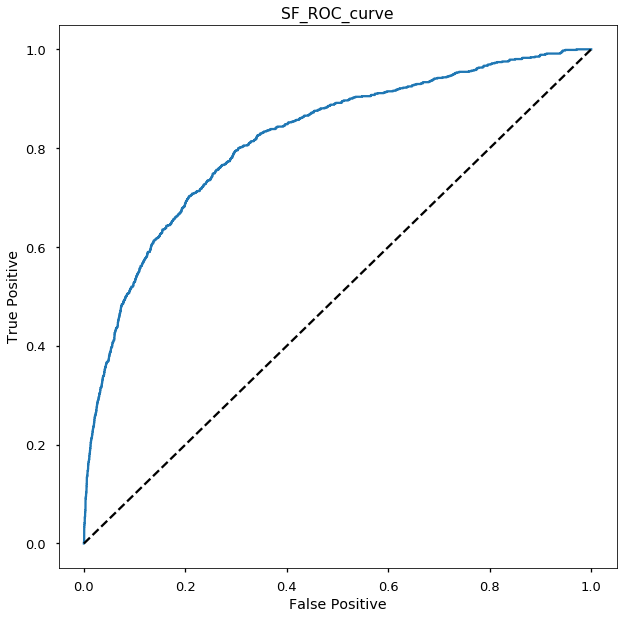

In [9]:
ROCplot, false_positive, true_positive, thresholds = MT.plot_ROC_curve(Xholdout,yholdout,estimator,title='SF_ROC_curve')

In [21]:
from sklearn.metrics import roc_curve, roc_auc_score
def plot_ROC_curve(Xdata,Ytrue,model,title):

    '''
    Plot ROC curve for this model 
    '''

    fires_holdout_predict = model.predict_proba(Xdata)

    fpr, tpr, thresholds1 = roc_curve(np.array(Ytrue).astype(int), fires_holdout_predict[:,1])
    
    score = roc_auc_score(np.array(Ytrue).astype(int), fires_holdout_predict[:,1])

    score_label = 'AOC score: %.3f' %score 

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    ax.plot(fpr,tpr,label=score_label)
    ax.set_xlabel("False Positive")
    ax.set_ylabel("True Positive")
    ax.plot(np.linspace(0,1,10),np.linspace(0,1,10),'k--')
    
    ax.fill_between(fpr, np.zeros(len(fpr)),
                     tpr, alpha=0.1,
                     color="b")

    ax.legend(loc='best')
    ax.grid()
    
    ax.set_title('%s' %title)
    fname = 'AOC_%s.png' %title
    plt.savefig(fname,dpi=400)

    return fig

/Users/rmartinshort/anaconda/envs/Insight/lib/python3.6/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


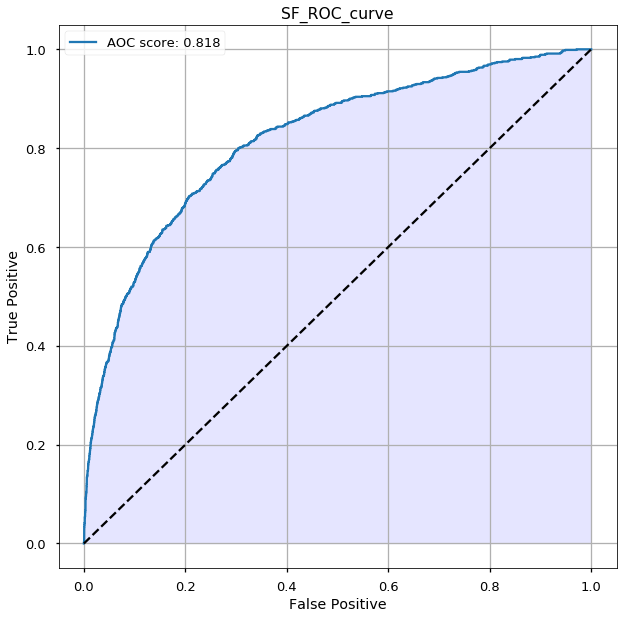

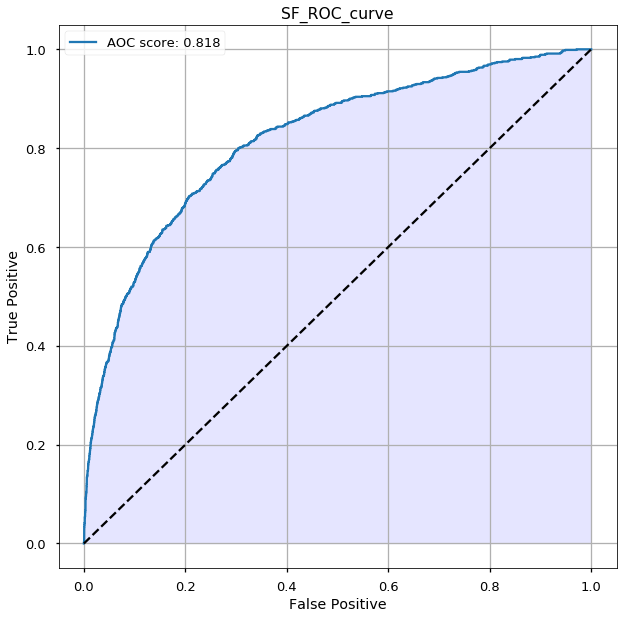

In [22]:
plot_ROC_curve(Xholdout,yholdout,estimator,title='SF_ROC_curve')

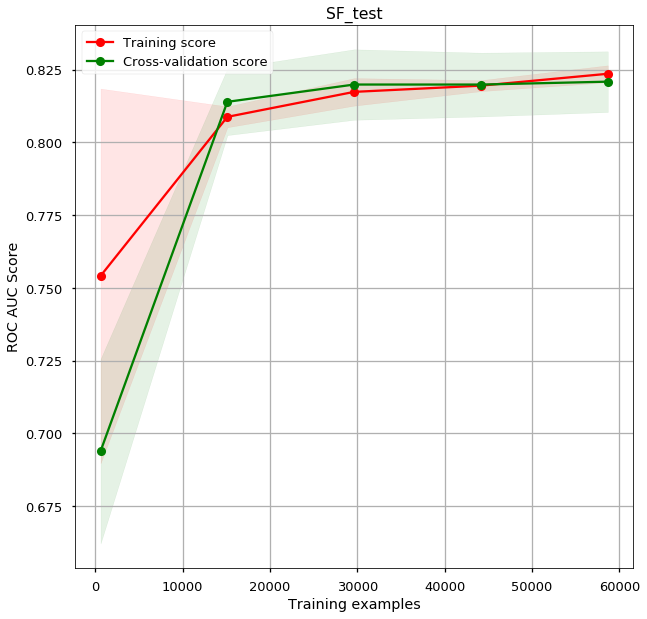

In [10]:
LC = MT.plot_Learning_curve(estimator,'SF_test',X,y,cv=5,n_jobs=4,train_sizes=np.linspace(.01, 1.0, 5))

Note that there are several things to consider when plotting learning curves:
- High bias case: If both the training and validation scores are low
- Low bias case: The training scores are high
- High variance case: The the gap between the training and validation scores is large
- Low variance: The gap is small

Shape of the curves: If they are fairly constant, then we know that adding more examples probably won't change much. This makes sense given our dataset because we have a lot of repeated data 